#### Import used libraries

In [20]:

%matplotlib inline 
import pandas as pd
import numpy as np
from sklearn.preprocessing import  LabelEncoder,OneHotEncoder
from sklearn.model_selection import  train_test_split,GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import  classification_report,confusion_matrix
from sklearn.metrics import  accuracy_score,precision_score,recall_score,f1_score,roc_curve,roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
#models 
from sklearn.linear_model import  LogisticRegression
from sklearn.tree import  DecisionTreeClassifier
from sklearn.naive_bayes import  CategoricalNB,GaussianNB
import warnings
import pickle 
# Ignore warnings
warnings.filterwarnings('ignore')

#### Load Data

In [21]:
df=pd.read_csv("data/train.csv")
df.head()

battery_power  blue  clock_speed  dual_sim    fc  four_g  int_memory  \
0            842     0          2.2         0   1.0     0.0         7.0   
1           1021     1          0.5         1   0.0     1.0        53.0   
2            563     1          0.5         1   2.0     1.0        41.0   
3            615     1          2.5         0   0.0     0.0        10.0   
4           1821     1          1.2         0  13.0     1.0        44.0   

   m_dep  mobile_wt  n_cores  ...  px_height  px_width     ram  sc_h  sc_w  \
0    0.6      188.0      2.0  ...       20.0     756.0  2549.0   9.0   7.0   
1    0.7      136.0      3.0  ...      905.0    1988.0  2631.0  17.0   3.0   
2    0.9      145.0      5.0  ...     1263.0    1716.0  2603.0  11.0   2.0   
3    0.8      131.0      6.0  ...     1216.0    1786.0  2769.0  16.0   8.0   
4    0.6      141.0      2.0  ...     1208.0    1212.0  1411.0   8.0   2.0   

   talk_time  three_g  touch_screen  wifi  price_range  
0         19        0             0     1            1  
1          7        1             1     0            2  
2          9        1             1     0            2  
3         11        1             0     0            2  
4         15        1             1     0            1  

[5 rows x 21 columns]

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             1995 non-null   float64
 5   four_g         1995 non-null   float64
 6   int_memory     1995 non-null   float64
 7   m_dep          1995 non-null   float64
 8   mobile_wt      1996 non-null   float64
 9   n_cores        1996 non-null   float64
 10  pc             1995 non-null   float64
 11  px_height      1996 non-null   float64
 12  px_width       1998 non-null   float64
 13  ram            1998 non-null   float64
 14  sc_h           1999 non-null   float64
 15  sc_w           1999 non-null   float64
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Note

- There are 21 columns: 20 attribute and one for classification
- There are some missing values in some features like (fc-four_g and etc)
- There are some categories features and others are numberic

In [23]:
numeric_features=["battery_power","fc","clock_speed","int_memory","m_dep","mobile_wt","pc","px_height","px_width","ram","sc_h","sc_w","talk_time"]
category_features=["n_cores","blue","dual_sim","four_g","three_g","touch_screen","wifi"]
target_feature="price_range"

numeric_df=df[numeric_features]
category_df=df[category_features]

Statistical categories and numeric features

In [24]:
def unique_classes(category_features:list,numeric_features:list,df:pd.DataFrame):
    unique_counts=[]
    missing_counts=[]
    
    # loop over categories features 
    for column in category_features:
        unique_counts.append(df[column].nunique())
        missing_counts.append(df[column].isna().sum())
    #unique_counts.sort()    
    cat_df=pd.DataFrame(data={"columns":category_features,"num_unique":unique_counts,"missing_counts":missing_counts})   
    
    # loop over numeric features 
    missing_counts=[]
    for column in numeric_features:
        missing_counts.append(df[column].isna().sum())
    numeric_df=pd.DataFrame(data={"columns":numeric_features,"missing_counts":missing_counts})   
    
    return cat_df,numeric_df

In [25]:
cat_count_df,numeric_count_df=unique_classes(category_features=category_features+[target_feature],numeric_features=numeric_features,df=df)
cat_count_df

columns  num_unique  missing_counts
0       n_cores           8               4
1          blue           2               0
2      dual_sim           2               0
3        four_g           2               5
4       three_g           2               0
5  touch_screen           2               0
6          wifi           2               0
7   price_range           4               0

In [26]:
numeric_count_df

columns  missing_counts
0   battery_power               0
1              fc               5
2     clock_speed               0
3      int_memory               5
4           m_dep               5
5       mobile_wt               4
6              pc               5
7       px_height               4
8        px_width               2
9             ram               2
10           sc_h               1
11           sc_w               1
12      talk_time               0

In [27]:
numeric_df.describe().T.round(2)


count     mean      std    min      25%     50%      75%  \
battery_power  2000.0  1238.52   439.42  501.0   851.75  1226.0  1615.25   
fc             1995.0     4.31     4.34    0.0     1.00     3.0     7.00   
clock_speed    2000.0     1.52     0.82    0.5     0.70     1.5     2.20   
int_memory     1995.0    32.05    18.15    2.0    16.00    32.0    48.00   
m_dep          1995.0     0.50     0.29    0.1     0.20     0.5     0.80   
mobile_wt      1996.0   140.27    35.38   80.0   109.00   141.0   170.00   
pc             1995.0     9.92     6.06    0.0     5.00    10.0    15.00   
px_height      1996.0   644.65   443.36    0.0   282.00   564.0   947.25   
px_width       1998.0  1251.29   432.35  500.0   874.25  1247.0  1633.00   
ram            1998.0  2124.26  1085.27  256.0  1206.50  2147.5  3065.50   
sc_h           1999.0    12.30     4.21    5.0     9.00    12.0    16.00   
sc_w           1999.0     5.77     4.36    0.0     2.00     5.0     9.00   
talk_time      2000.0    11.01     5.46    2.0     6.00    11.0    16.00   

                  max  
battery_power  1998.0  
fc               19.0  
clock_speed       3.0  
int_memory       64.0  
m_dep             1.0  
mobile_wt       200.0  
pc               20.0  
px_height      1960.0  
px_width       1998.0  
ram            3998.0  
sc_h             19.0  
sc_w             18.0  
talk_time        20.0

### Exploratory Data Analysis

- Categories Features

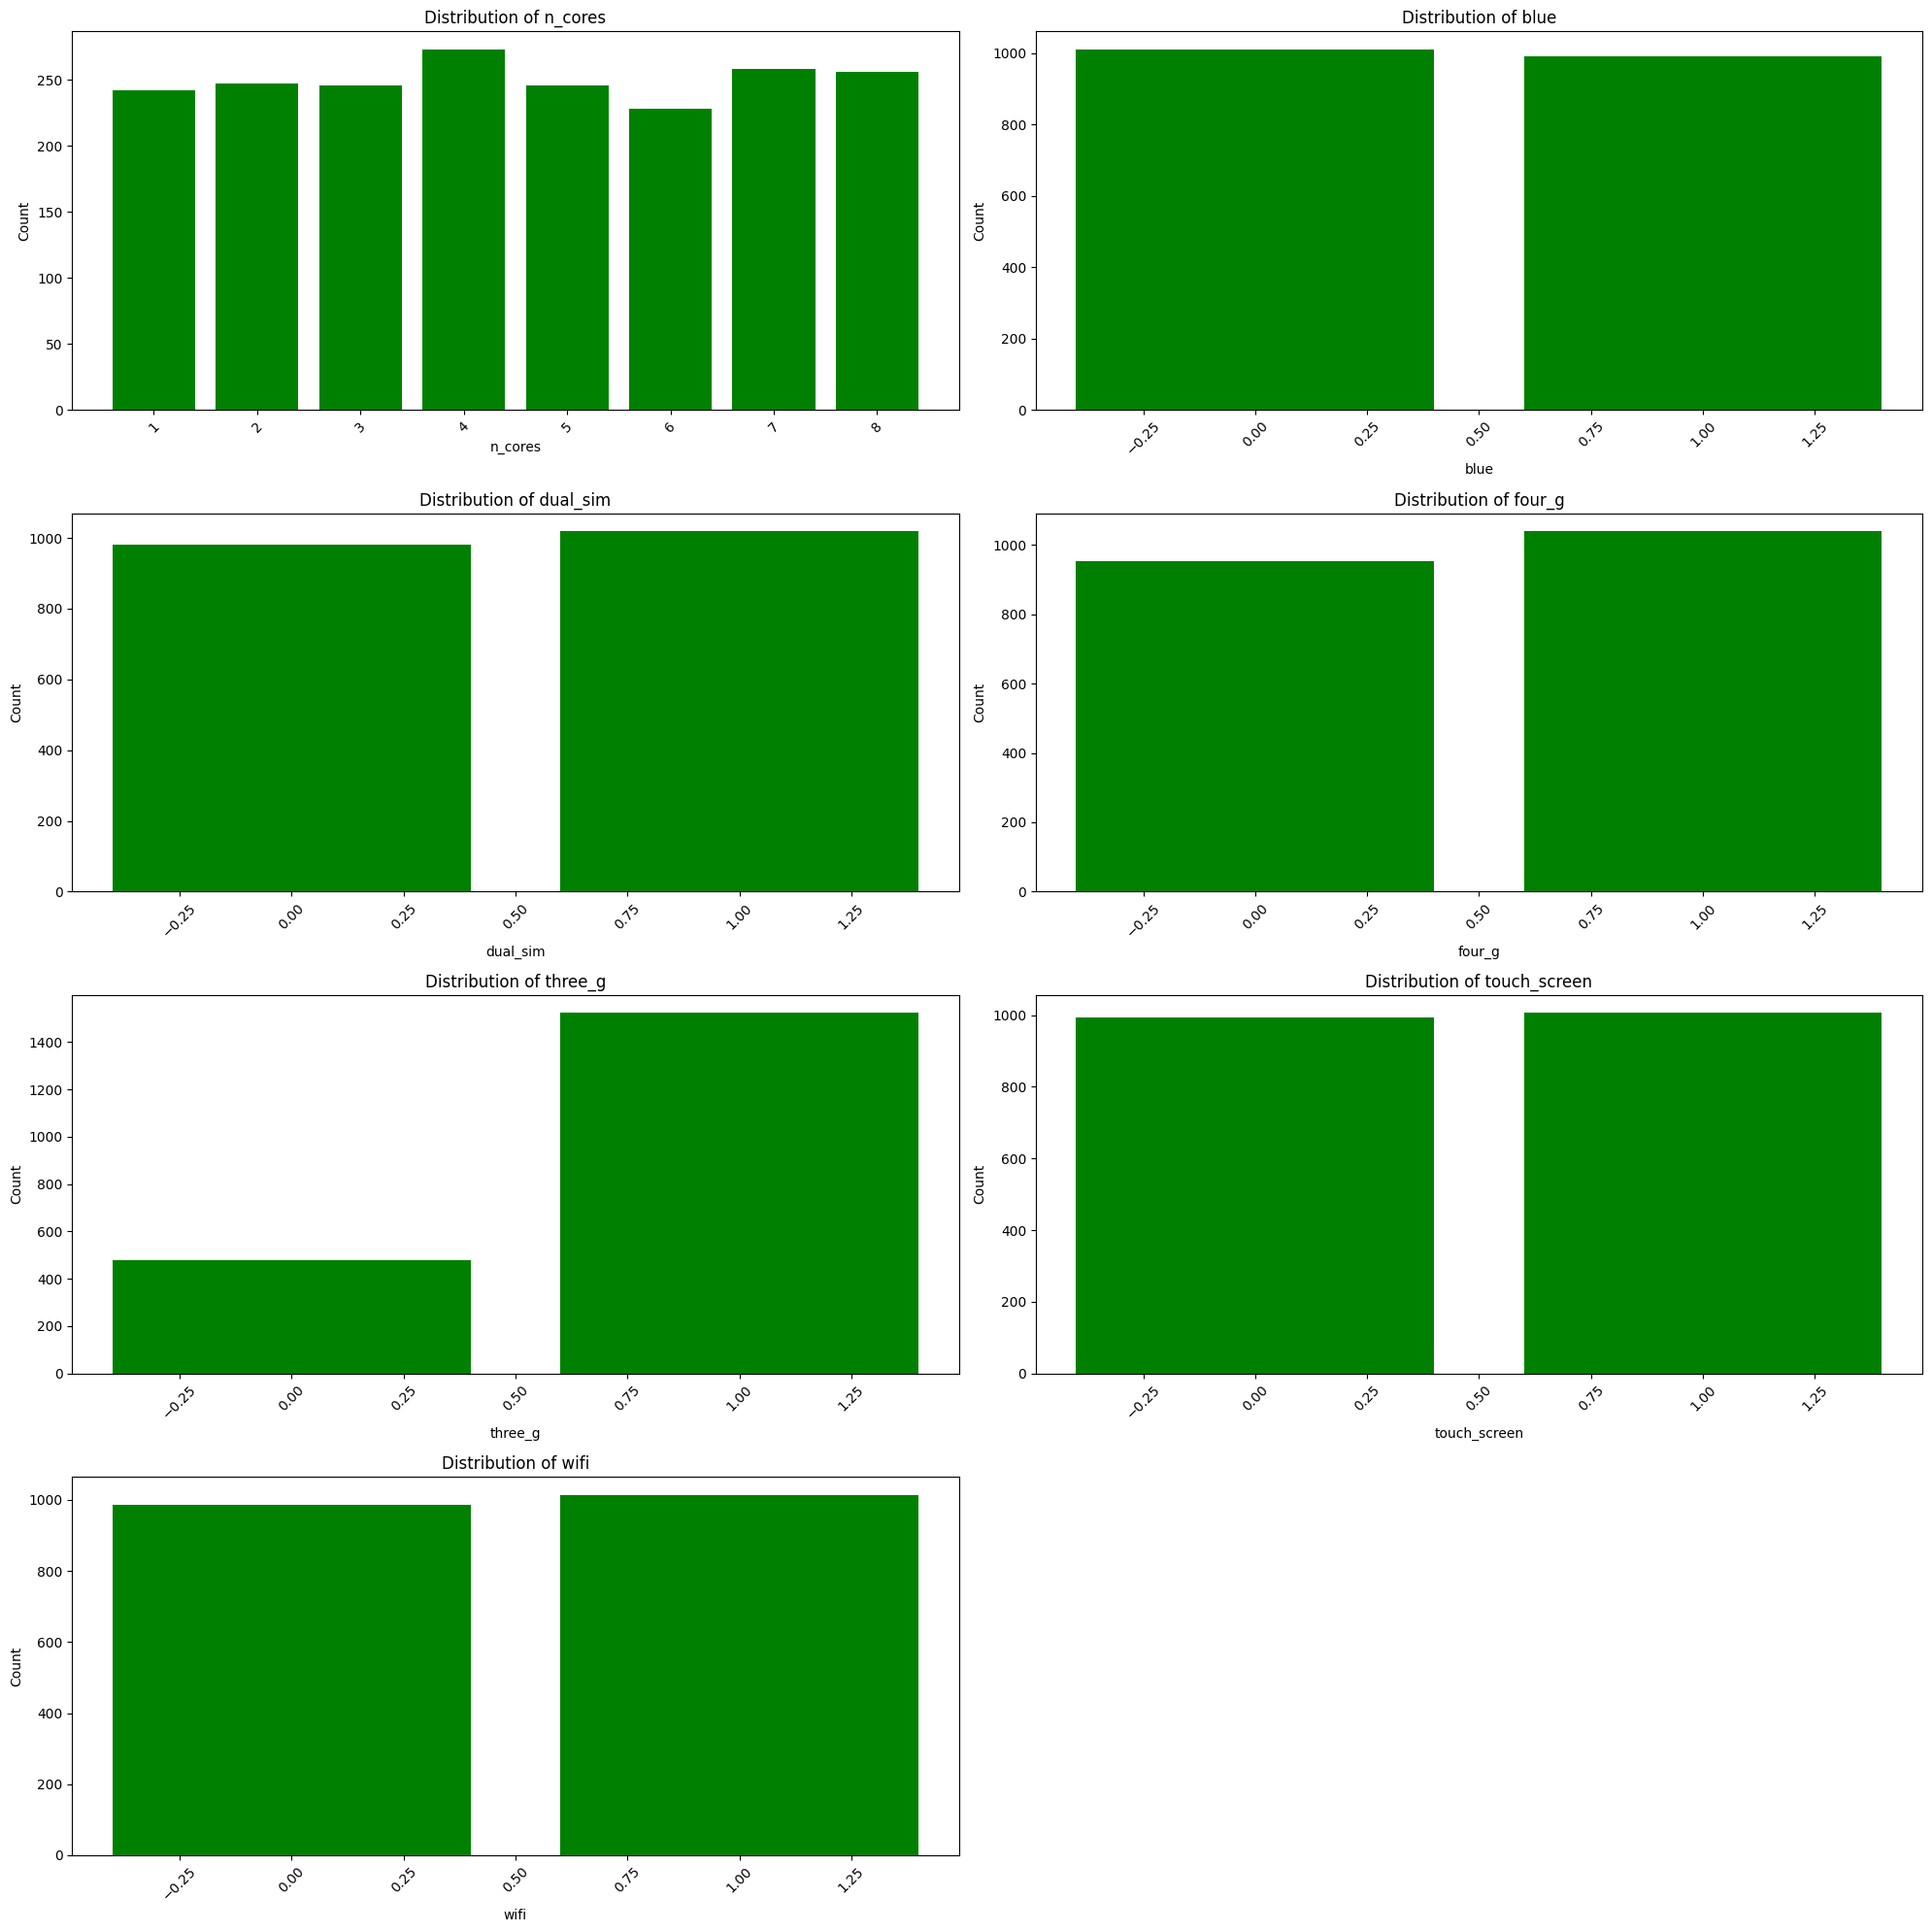

In [28]:
def explore_categories_count(df:pd.DataFrame,category_features:list,num_rows=4,num_cols=2):
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    axes = axes.flatten()

    for i, feature in enumerate(category_features):
        category_counts = df[feature].value_counts()
        axes[i].bar(category_counts.index, category_counts.values,color="g")
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)


    if len(category_features) < num_rows * num_cols:
        for j in range(len(category_features), num_rows * num_cols):
            axes[j].axis('off')


    plt.tight_layout()
    plt.show()
explore_categories_count(df=category_df,category_features=category_features)    

We notice at above plotting the **categories feature are almost balanced** except **three_g** attribute 

- Numeric Features

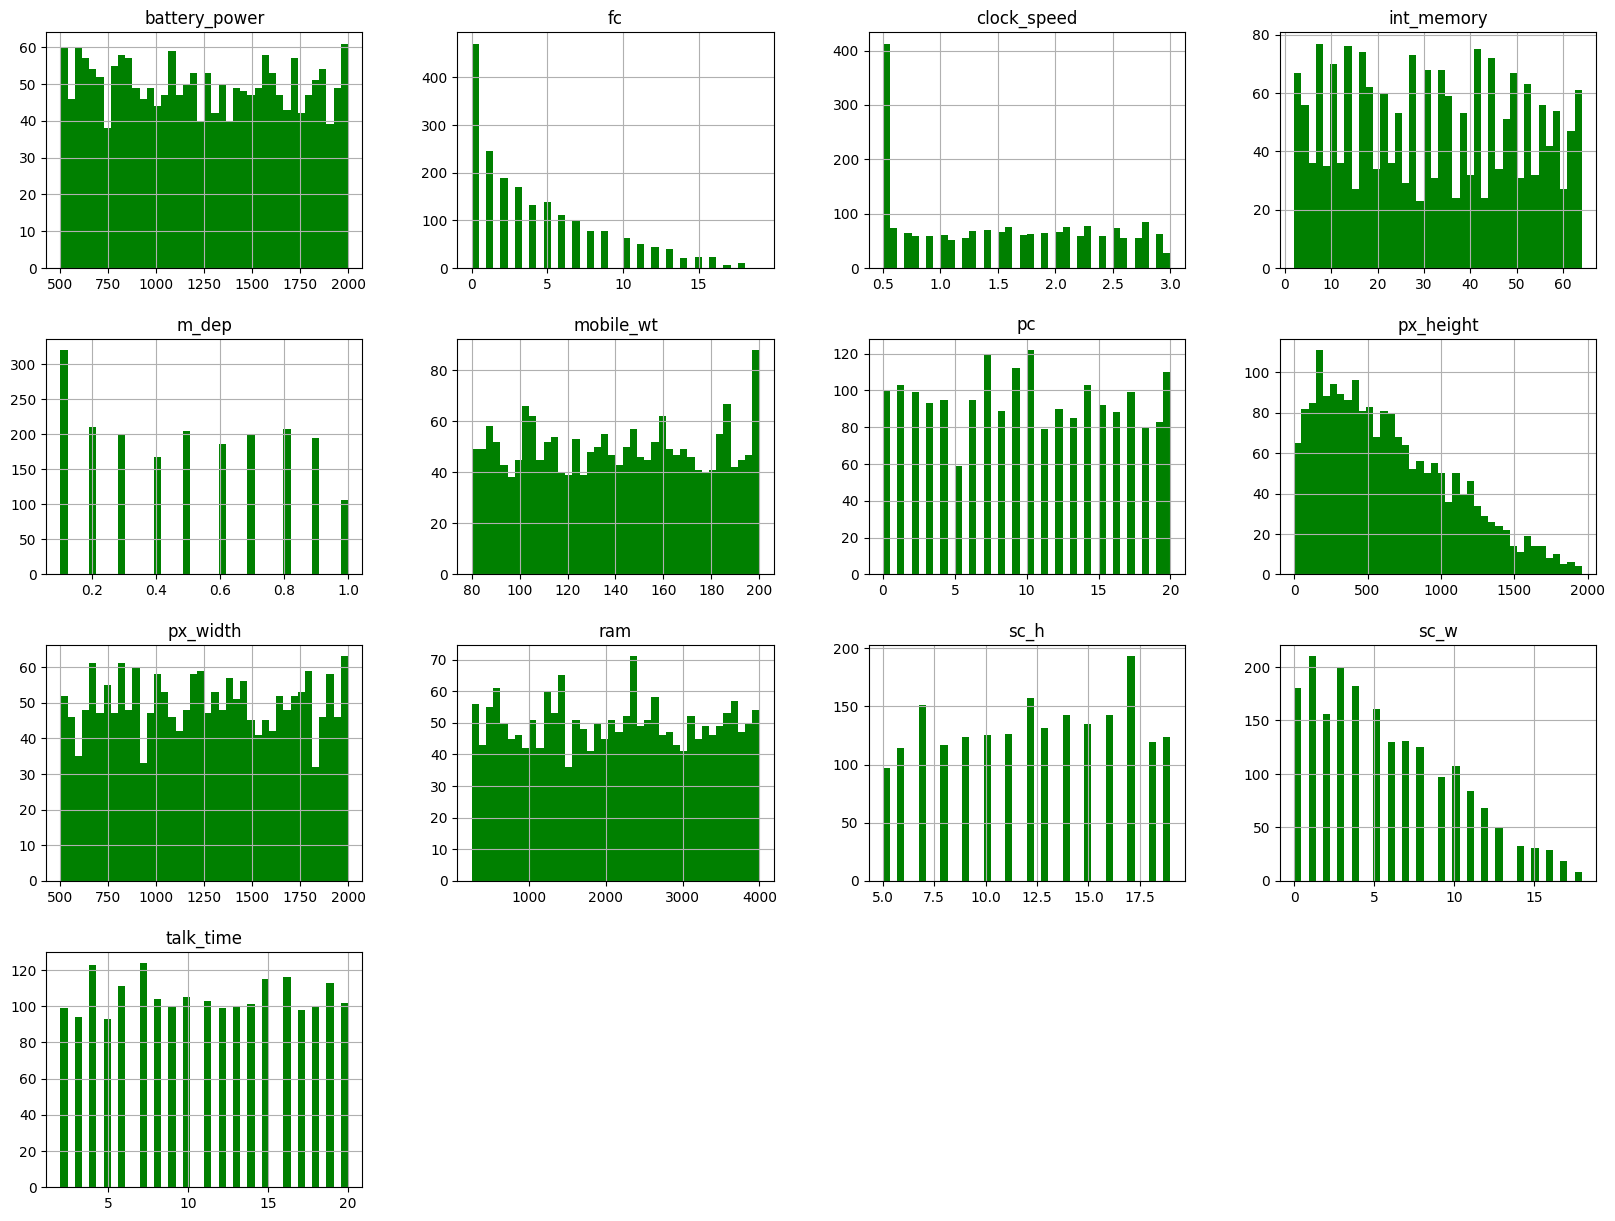

In [29]:
numeric_df.hist(bins=40, figsize=(20,15),color="green")
plt.show()

- As we see above distribution of numeroc featrues each one distribute the values and count for each value
- We noticed in some features like **(px_height - sc_w)** have values close to zero which means outlier/noise values

### Preprocessing Data

- Split Device Attributes and Target 

In [30]:
X=df.drop(target_feature,axis=1)
y=df[target_feature]

#### Pipelines missing values $ Scaling

- Missing values handler
- Scaling

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

"""
# create pipeline to preprocess numeric values 
# Simple Imputer we pass it median stratergy to calculate meadin value and fill null values with it 
# then we use Feature scaling to normalize the values as we noticed before there are different scale value in numeric featires
"""

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),('std_scaler', StandardScaler()),])

"""
# The thing for category features create pipeline to preprocess 
# Simple Imputer we pass it most_frequent stratergy to fill null values with it 
"""
cat_pipeline=Pipeline([("cat", SimpleImputer(strategy="most_frequent"))])

# aggregrate the two pipelines together and transform values
full_pipeline = ColumnTransformer([("num", num_pipeline, numeric_features),("cat", SimpleImputer(strategy="most_frequent"), category_features),])
X_transformed = full_pipeline.fit_transform(X)

- Reconstract prepared data

In [32]:
df_prepared=pd.DataFrame(data=X_transformed,columns=numeric_features+category_features)
df_prepared[target_feature]=y
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   float64
 1   fc             2000 non-null   float64
 2   clock_speed    2000 non-null   float64
 3   int_memory     2000 non-null   float64
 4   m_dep          2000 non-null   float64
 5   mobile_wt      2000 non-null   float64
 6   pc             2000 non-null   float64
 7   px_height      2000 non-null   float64
 8   px_width       2000 non-null   float64
 9   ram            2000 non-null   float64
 10  sc_h           2000 non-null   float64
 11  sc_w           2000 non-null   float64
 12  talk_time      2000 non-null   float64
 13  n_cores        2000 non-null   float64
 14  blue           2000 non-null   float64
 15  dual_sim       2000 non-null   float64
 16  four_g         2000 non-null   float64
 17  three_g        2000 non-null   float64
 18  touch_sc

#### Feature Selection

- Features correlation

In [33]:
def data_correlations(features:list,correlations):
    fig=plt.figure(figsize=(8,8))
    ax=fig.add_subplot(1,1,1)
    cax=ax.matshow(correlations,vmin=-1,vmax=1,)
    fig.colorbar(cax)
    ticks = np.arange(0,len(features))

    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.set_xticklabels(features)
    ax.set_yticklabels(features)
    ax.tick_params(axis='x', rotation=90)
    plt.show()

In [34]:
correlations=df_prepared.corr(method="pearson")
print(correlations["price_range"].sort_values(ascending=False))

price_range      1.000000
ram              0.917017
battery_power    0.200723
px_width         0.166082
px_height        0.148009
int_memory       0.042527
sc_w             0.038814
pc               0.034598
fc               0.024893
three_g          0.023611
sc_h             0.023315
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.015668
n_cores          0.004695
m_dep           -0.000078
clock_speed     -0.006606
touch_screen    -0.030411
mobile_wt       -0.032433
Name: price_range, dtype: float64


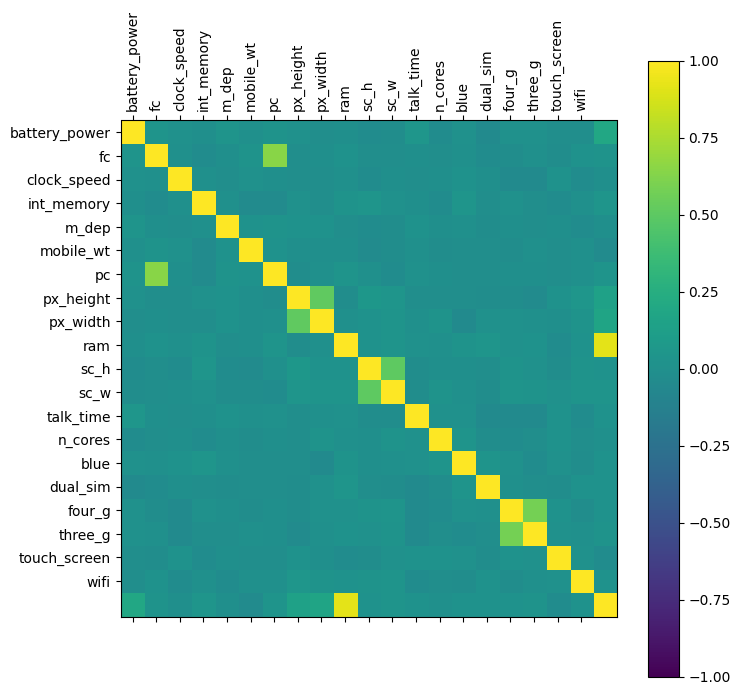

In [35]:
data_correlations(features=numeric_features+category_features,correlations=correlations)

- We noticed **ram** is most highly correlated with **price_range**
- **sc_w** and **sc_h** is highly correlated 
- **px_h** and **px_w** is highly correlated
- **fc** and **pc** is highly correlated

### Training

In [36]:
X=df_prepared.drop(target_feature,axis=1)
y=df_prepared[target_feature]
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0,test_size=0.2)

In [37]:
def evaluation_metrices(y_predict,y_test,avg="macro"):
    accuracy=round(accuracy_score(y_test,y_predict)*100,3)
    precission=round(precision_score(y_test,y_predict,average=avg)*100,3)
    recall=round(recall_score(y_test,y_predict,average=avg)*100,3)
    f1=round(f1_score(y_test,y_predict,average=avg)*100,3)
    return {"accuracy_score":accuracy,"precission_score":precission,"recall_score":recall,"f1_score":f1}

In [38]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports and confusion matrix
    '''
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    print('\n')
    

In [39]:
def visualize_cf_matric(y_test,y_predicted):
    # confusion matrix
    cf_matrix=confusion_matrix(y_test,y_predicted)
    # visualize cf
    plt.figure(figsize=(6,4))
    sns.heatmap(cf_matrix,annot=True,fmt='g')
    plt.xlabel("Predicted")
    plt.xlabel("True")
    plt.show()

In [40]:
def finetune_hyperparameters(clf, param_grid, X_train, y_train):
    """
    Tunes the hyperparameters of a classifier using GridSearchCV and cross-validation.

    Parameters:
    clf (estimator): A classifier object that implements the estimator interface.
    param_grid (dict): A dictionary of hyperparameter values to search over using GridSearchCV.
    X_train (array-like): The training input samples.
    y_train (array-like): The target values for the training input samples.
    
    Returns:
    estimator: The best classifier with the optimal hyperparameters.
    """
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_

#### Logistic Regression

In [48]:
lr_model=LogisticRegression()
optimized_lr_model=finetune_hyperparameters(clf=lr_model,X_train=X_train,y_train=y_train,param_grid=[
    {"max_iter":[100,500,1000,10000],"C":[0.01,0.1,1,10,100]},
    
])


/home/mohamad/Documents/Machine-learning-projects/housing/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mohamad/Documents/Machine-learning-projects/housing/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

Best hyperparameters:
 {'C': 100, 'max_iter': 500}


In [49]:
y_lr_predicted=optimized_lr_model.predict(X_test)
lr_metrices_evaluation=evaluation_metrices(y_predict=y_lr_predicted,y_test=y_test)

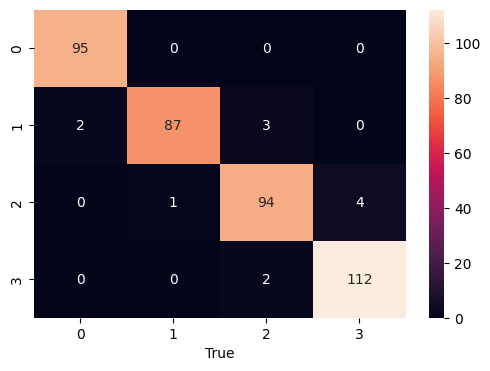

In [50]:
visualize_cf_matric(y_test=y_test,y_predicted=y_lr_predicted)

In [51]:
model_evaluation(clf=optimized_lr_model,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,model_name="Logisitic Regression")


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       405
           1       0.99      0.99      0.99       408
           2       0.98      0.99      0.99       401
           3       1.00      0.99      0.99       386

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        95
           1       0.99      0.95      0.97        92
           2       0.95      0.95      0.95        99
           3       0.97      0.98      0.97       114

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97 

##### Conclusion

We notice the accurcy on **training data is 99%** and on the **test data is 97%** It's very
good result for Logistic regression

#### Decission Tree

In [52]:
dt_model=DecisionTreeClassifier()
dt_optimized_model=finetune_hyperparameters(clf=dt_model,X_train=X_train,y_train=y_train,param_grid={
    'max_depth': np.arange(1, 15),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 10),
    'max_features': [None, 'sqrt', 'log2']
})

Best hyperparameters:
 {'max_depth': 14, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [53]:
y_dt_predicted=dt_optimized_model.predict(X_test)
dt_metrices_evaluation=evaluation_metrices(y_predict=y_dt_predicted,y_test=y_test)

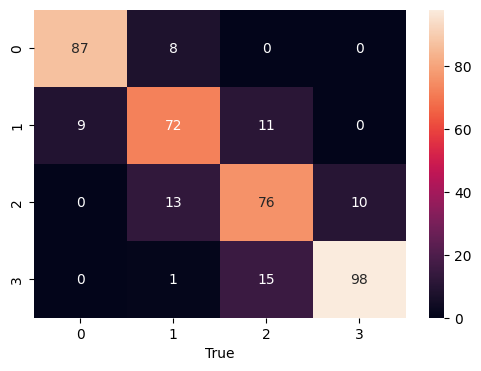

In [54]:
visualize_cf_matric(y_test=y_test,y_predicted=y_dt_predicted)

In [55]:
model_evaluation(clf=dt_optimized_model,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,model_name="Decision Tree")


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       405
           1       0.95      0.97      0.96       408
           2       0.97      0.96      0.97       401
           3       0.99      0.97      0.98       386

    accuracy                           0.97      1600
   macro avg       0.97      0.97      0.97      1600
weighted avg       0.97      0.97      0.97      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.92      0.91        95
           1       0.77      0.78      0.77        92
           2       0.75      0.77      0.76        99
           3       0.91      0.86      0.88       114

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83 

##### Conclusion

As we noticed There are a gap between accuracy on **training data 97%** and on **testing is 83%**
we can say there are overfitting using Decission Tree classifier

#### Compare models

In [56]:
models_comparison_df=pd.DataFrame({
    "Logisic Regression": lr_metrices_evaluation,
    "Decission Tree":dt_metrices_evaluation,
})
models_comparison_df

Logisic Regression  Decission Tree
accuracy_score                97.000          83.250
precission_score              97.076          83.118
recall_score                  96.940          83.143
f1_score                      96.991          83.107

##### Conclusion

As we discoverd above we find **Logistic regression** get higher accuracy than **Decission Tree**
for test and train data, There is no overfitting or underfitting by using **Logistic regression**

### Save Model 

In [57]:
def save_model(model,path):
    with open(path,"wb")as file:
        pickle.dump(model,file)
save_model(model=optimized_lr_model,path="server/data/lr_predictor")
save_model(model=full_pipeline,path="server/data/pipeline_normalizer")        

### Test Model on Testing Data

- Load Test Data

In [58]:
test_df=pd.read_csv("data/test.csv")


In [59]:
picked_test_df=test_df[:10][numeric_features+category_features]

In [60]:
from server.service.device_price_service import  DevicePricingService
predictDevicePrice=DevicePricingService()

In [61]:
predicted=predictDevicePrice.predict(input_case=picked_test_df)
print(predicted)

[3 3 2 3 1 3 3 1 3 0]


In [62]:
predicted_classed=predictDevicePrice.invers_transform_target(predicted=predicted)
print(predicted_classed)

['very high', 'very high', 'high', 'very high', 'medium', 'very high', 'very high', 'medium', 'very high', 'low']
